In [17]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [18]:
IMAGE_SIZE = 32
DATASET_PATH = "./dataset"

In [19]:
images = []

# Load Image
for subdir_name in os.listdir(DATASET_PATH):
    for image_name in os.listdir(f"{DATASET_PATH}/{subdir_name}"):
        image = tf.keras.preprocessing.image.load_img(f"{DATASET_PATH}/{subdir_name}/{image_name}",
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)

# Convert to numpy array
images = np.array(images)

# Normalize images
images = images/np.float32(255)


# Reshape iamges
images = np.reshape(images, (images.shape[0], IMAGE_SIZE * IMAGE_SIZE * 3))

In [20]:
# Train Test Split
train_size = int(len(images) * 0.6)

images = tf.random.shuffle(images, seed=19)
train_data = images[:train_size]
test_data = images[train_size:]

In [21]:
# Constructing RBM Class
class RBM(object):
    def __init__(self, input_size, output_size, learning_rate=0.01, batch_size=128):
        self.input_size = input_size
        self.output_size =  output_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Initialize weight, hidden bias, and visible bias
        self.w = tf.zeros([input_size, output_size], np.float32)
        self.hb = tf.zeros([output_size], np.float32)
        self.vb = tf.zeros([input_size], np.float32)
    #Create Probabilty H Given V
    def probability_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb) #Sigmoid probability 0 sampai 1
        
    #Create Probabilty V Given H
    def probability_v_given_h(self, hidden, w, hb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + hb)
        
    #Create Sample Prob Following Prob's Shape
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs)))) #tf sign angka random dari - sampai + , - -> -1, 0->0, + -> 1
    #fungsi aktivasi relu mengubah negatif jadi 0
        
    def update_weight_and_bias(self, positive_gradient, negative_gradient, batch, h0, v1, h1):
        self.w = self.w + self.learning_rate * (positive_gradient - negative_gradient) / tf.dtypes.cast(tf.shape(batch)[0], tf.float32)
        self.vb = self.vb + self.learning_rate * tf.reduce_mean(batch - v1, 0)
        self.hb = self.hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)
    
    # Training using constrative divergence
    def train(self, x_train, epochs=100):
        losses = []
        
        for epoch in range(epochs):
            for start, end in zip(range(0, len(x_train), self.batch_size), range(self.batch_size, len(x_train), self.batch_size)):
                batch = x_train[start:end]
                
                h0 = self.sample_prob(self.probability_h_given_v(batch, self.w, self.hb)) # Probability of hidden units being on given the visible units (input data).
                v1 = self.sample_prob(self.probability_v_given_h(h0, self.w, self.vb)) # Calculates the probability of visible units being on given the hidden units (h0).
                h1 = self.probability_h_given_v(v1, self.w, self.hb) # Calculates the probability of hidden units being on given the reconstructed visible units (v1). This is used for the negative gradient.
                
                positive_gradient = tf.matmul(tf.transpose(batch), h0)
                negative_gradient = tf.matmul(tf.transpose(v1), h1)
                
                self.update_weight_and_bias(positive_gradient, negative_gradient, batch, h0, v1, h1)
            
            # Reconstruction Error
            loss = tf.reduce_mean(tf.square(batch - v1))
            print(f"Epoch: {epoch}, Reconstruction Loss: {loss}")
            
            losses.append(loss)
        return losses
    
    # Reconstruct Image from new input
    def rbm_reconstruction(self, x):
        h = self.probability_h_given_v(x, self.w, self.hb)
        reconstruct = self.probability_v_given_h(h, self.w, self.vb)
        return reconstruct

In [22]:
#Train Model
model = RBM(train_data.shape[1], 1000)
losses = model.train(train_data, 100)

Epoch: 0, Reconstruction Loss: 0.1926472783088684
Epoch: 1, Reconstruction Loss: 0.18488335609436035
Epoch: 2, Reconstruction Loss: 0.1747889518737793
Epoch: 3, Reconstruction Loss: 0.16516251862049103
Epoch: 4, Reconstruction Loss: 0.16013948619365692
Epoch: 5, Reconstruction Loss: 0.1555677205324173
Epoch: 6, Reconstruction Loss: 0.151933953166008
Epoch: 7, Reconstruction Loss: 0.14917311072349548
Epoch: 8, Reconstruction Loss: 0.14628851413726807
Epoch: 9, Reconstruction Loss: 0.1442263275384903
Epoch: 10, Reconstruction Loss: 0.14146704971790314
Epoch: 11, Reconstruction Loss: 0.14099211990833282
Epoch: 12, Reconstruction Loss: 0.1380079835653305
Epoch: 13, Reconstruction Loss: 0.13714435696601868
Epoch: 14, Reconstruction Loss: 0.1376274824142456
Epoch: 15, Reconstruction Loss: 0.13498401641845703
Epoch: 16, Reconstruction Loss: 0.13312846422195435
Epoch: 17, Reconstruction Loss: 0.1346665471792221
Epoch: 18, Reconstruction Loss: 0.13290834426879883
Epoch: 19, Reconstruction Loss:

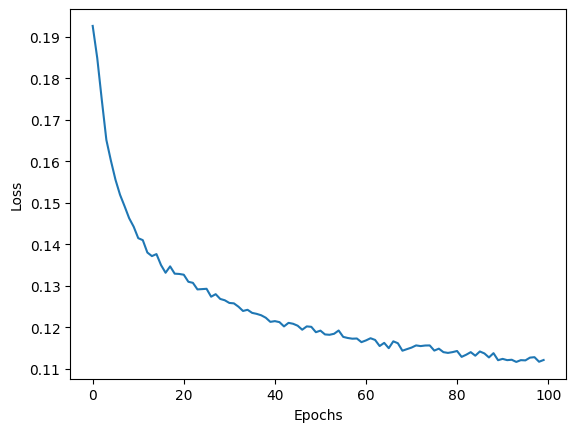

In [23]:
#Plotting Reconstruction Loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

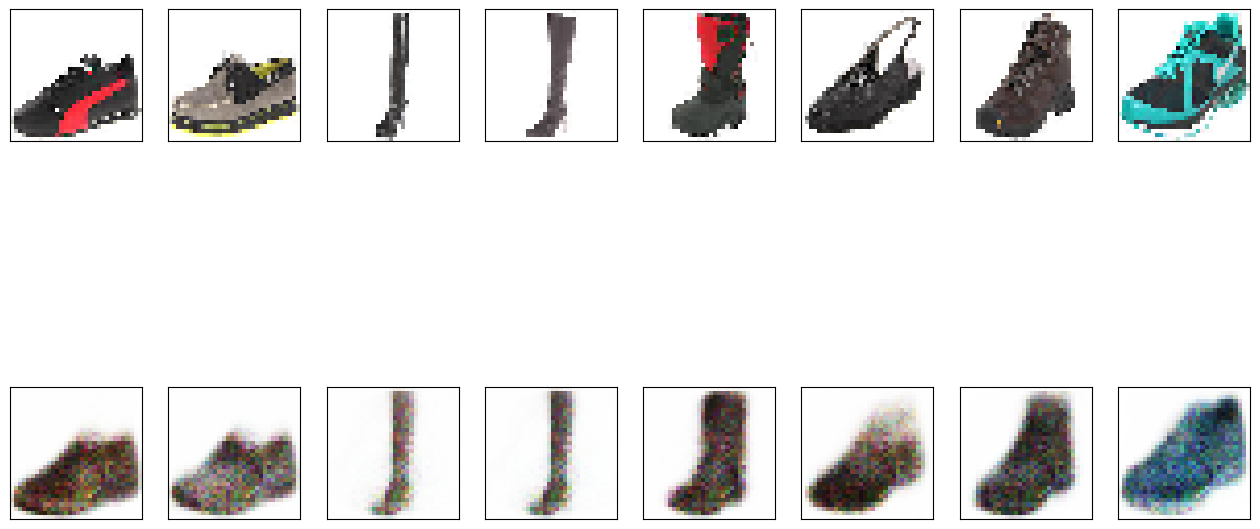

In [24]:
# Testing Model
output = model.rbm_reconstruction(test_data)

row, col=2, 8
idx = np.random.randint(0, 100, row * col)

f, axarr = plt.subplots(row, col, figsize=(16, 9))
for fig, row in zip([test_data, output], axarr):
    for i, ax in zip(idx, row):
        ax.imshow(tf.reshape(fig[i], [IMAGE_SIZE, IMAGE_SIZE, 3]))
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
plt.show()

# f isi obeject dari figure
# axarr = grid